## Deep learning example from Accounting/Finance

The following example demonstrates a simple example of deep learning that uses accounting/finance data. It also demonstrates, how to implement a deep learning model to traditional structured data. However, it also shows how deep learning is usually not the best option for structured data with relatively small datasets (<100k observations). Deep learning models perform better with large unstructured datasets.

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

The data has a little under 20k observations. The variables are different financial ratios and board characteristics of S&P1500 companies.

In [2]:
compu_df = pd.read_csv('_data.txt',delimiter='\t')

In [3]:
compu_df

,GVKEY,datadate,fyear,cusip,conm,act,at,bkvlps,capx,ceq,...,ind_chairman_is_ex_ceo,ind_independent_board_members,ind_strictly_independent_board_members,ind_board_member_affiliations,ind_non_executive_board_members,ind_board_gender_diversity_percent,ind_board_specific_skills_percent,ind_executive_members_gender_diversity_percent,ind_average_board_tenure,ind_board_member_compensation
0,21542,20081231,2008,000360206,AAON INC,80.118,140.743,5.6088,9.610,96.522,...,0.0,87.500,57.140,1.425,90.91,13.395,50.61,7.735,8.270,1650394.0
1,21542,20091231,2009,000360206,AAON INC,96.240,156.211,6.8544,9.774,117.999,...,0.0,87.500,50.000,1.180,90.00,12.915,60.00,6.670,8.705,1590889.5
2,21542,20101231,2010,000360206,AAON INC,91.748,160.277,7.0725,17.470,116.739,...,0.0,84.620,51.925,1.000,90.00,11.110,58.33,9.090,8.780,1801674.0
3,21542,20111231,2011,000360206,AAON INC,84.387,178.981,4.9762,35.914,122.504,...,0.0,86.670,50.000,1.090,90.00,11.110,57.14,10.000,9.180,1847006.5
4,21542,20121231,2012,000360206,AAON INC,91.546,193.493,5.6341,14.147,138.136,...,0.0,87.500,50.000,1.190,90.00,14.290,54.55,9.090,9.170,1810953.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19632,28191,20151231,2015,V7780T103,ROYAL CARIBBEAN GROUP,837.022,20921.855,36.9876,1613.340,8063.039,...,1.0,84.620,50.000,0.905,83.33,16.670,53.85,12.500,8.880,1744895.0
19633,28191,20161231,2016,V7780T103,ROYAL CARIBBEAN GROUP,748.305,22310.324,42.5054,2494.363,9121.412,...,1.0,83.330,50.000,0.880,83.33,16.670,53.85,14.290,9.340,1737800.0
19634,28191,20171231,2017,V7780T103,ROYAL CARIBBEAN GROUP,843.028,22296.317,50.1659,564.138,10702.303,...,1.0,83.330,50.000,0.885,83.33,20.000,57.14,13.395,9.105,1793588.5
19635,28191,20181231,2018,V7780T103,ROYAL CARIBBEAN GROUP,1242.044,27698.270,53.1319,3660.028,11105.461,...,1.0,85.710,50.000,0.745,81.82,22.220,58.33,14.290,9.180,1858984.0


We use only variables with few missing values, because the benefits of deep learning are seen in large datasets. The variables are different financial ratios (Compustat). There are also many heavily correlating variables included, but this should not be a serious issue with neural networks.

In [4]:
variables = ['at', 'bkvlps','capx', 'ceq', 'csho', 'cstk', 'dlc', 'dltt', 'dvc', 'ebit',
       'ibc', 'icapt', 'lt', 'ni', 'pstk', 'pstkl','pstkrv', 're', 'sale', 'seq', 'costat', 'prcc_c',
       'prcc_f', 'sic', 'mkvalt','tobin', 'yld', 'age', 'tridx', 'mb',
       'cap_int', 'lvg', 'roa', 'roe', 'roi']

In [5]:
compu_df[variables].isna().sum()

at           3
bkvlps      34
capx        53
ceq          3
csho        11
cstk        13
dlc          9
dltt        81
dvc         77
ebit        15
ibc         17
icapt        4
lt          49
ni           7
pstk         4
pstkl       37
pstkrv      19
re          12
sale         7
seq          3
costat       0
prcc_c       8
prcc_f       6
sic          0
mkvalt      13
tobin       13
yld         85
age          0
tridx      172
mb          36
cap_int     53
lvg         86
roa          7
roe         16
roi          8
dtype: int64

In [6]:
compu_df[variables] = compu_df[variables].clip(lower=compu_df[variables].quantile(0.01),
                                               upper=compu_df[variables].quantile(0.99),axis=1)

In [7]:
compu_df['current_roa'] = compu_df['roa']

Lag everything else

In [8]:
compu_df[variables] = compu_df.groupby(['conm']).shift()[variables]

We have to drop all missing values, because othwerise we can not optimize the network using gradient descent algorithm.

I add industry, SP500 dummy and year separately as I do not want to winsorize or lag these variables.

In [9]:
compu_df[variables + ['fyear','ind','sp500','current_roa']] = compu_df[variables + ['fyear','ind','sp500','current_roa']].dropna()

In [10]:
compu_df[variables + ['fyear','current_roa']].head(30)

,at,bkvlps,capx,ceq,csho,cstk,dlc,dltt,dvc,ebit,...,age,tridx,mb,cap_int,lvg,roa,roe,roi,fyear,current_roa
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,140.743,5.6088,9.610,96.522,17.209,0.071,2.992,0.000,5.621,43.388,...,204.0,1.070373,3.722721,0.068280,0.030998,0.203129,0.079563,0.296192,2009.0,0.177459
2,156.211,6.8544,9.774,117.999,17.215,0.071,0.076,0.000,6.201,43.754,...,216.0,1.017457,2.843429,0.062569,0.000644,0.177459,0.082621,0.234926,2010.0,0.136601
3,160.277,7.0725,17.470,116.739,16.506,0.068,0.000,0.000,6.067,32.715,...,228.0,1.494462,3.988689,0.108999,0.000000,0.136601,0.047020,0.187547,2011.0,0.078142
4,178.981,4.9762,35.914,122.504,24.618,0.098,4.575,0.000,5.935,23.971,...,240.0,1.646141,4.117600,0.200658,0.037346,0.078142,0.027727,0.114168,2012.0,0.141860
5,193.493,5.6341,14.147,138.136,24.518,0.098,0.000,0.000,8.840,44.238,...,252.0,1.706581,3.704230,0.073114,0.000000,0.141860,0.053644,0.198710,2013.0,0.174277
6,215.444,4.4702,9.041,164.106,36.711,0.147,0.000,0.000,7.428,55.803,...,264.0,3.949485,7.147331,0.041965,0.000000,0.174277,0.032012,0.228797,2014.0,0.189424
7,233.117,3.2208,16.127,174.059,54.042,0.216,0.000,0.000,9.656,71.563,...,276.0,4.185799,6.951689,0.069180,0.000000,0.189424,0.036494,0.253696,2015.0,0.196381
8,232.854,3.3750,20.967,178.918,53.012,0.212,0.000,0.000,11.857,71.695,...,288.0,4.381591,6.880000,0.090044,0.000000,0.196381,0.037149,0.255581,2016.0,0.208069
9,256.530,3.9106,26.604,205.898,52.651,0.211,0.000,0.000,12.676,79.574,...,300.0,6.286182,8.451389,0.103707,0.000000,0.208069,0.030674,0.259235,2017.0,0.183631


I remove the first year (2008), because we do not have any observations there due to the lag procedure.

In [11]:
compu_df = compu_df[compu_df['fyear'] > 2008.]

We try to predict current ROA with the last year's variable values.

In [12]:
y_df = compu_df['current_roa']

In [13]:
x_df = compu_df[variables + ['fyear','ind','sp500']]

Train/test split

In [14]:
from sklearn.model_selection import train_test_split

Tensoflow does not like Pandas dataframes, so I change them to Numpy array.s

In [15]:
# Split data into training and test sets
x_train, x_test , y_train, y_test = train_test_split(x_df.values, y_df.values, test_size=0.20, random_state=1)

In [16]:
type(x_train)

numpy.ndarray

In [17]:
len(x_train), len(x_test)

(14017, 3505)

Let's check that there is no missing values any more.

In [18]:
compu_df[variables+['current_roa','fyear']].isna().sum()

at             0
bkvlps         0
capx           0
ceq            0
csho           0
cstk           0
dlc            0
dltt           0
dvc            0
ebit           0
ibc            0
icapt          0
lt             0
ni             0
pstk           0
pstkl          0
pstkrv         0
re             0
sale           0
seq            0
costat         0
prcc_c         0
prcc_f         0
sic            0
mkvalt         0
tobin          0
yld            0
age            0
tridx          0
mb             0
cap_int        0
lvg            0
roa            0
roe            0
roi            0
current_roa    0
fyear          0
dtype: int64

### Densely connected network
Let's build a traditional densely connected neural network. We could also use recurrent or LSTM networks, but we would need to reorganize data in that case.

![image.png](./images/feed_forward.png)!

One way to define a neural network with Keras is a single **Sequential**-command that has the layers in a list as a parameter. The densely connected layers have **ReLU** as an activation function. The last layer has one neuron, because we want to have a single valua as an output (current ROA). There is also no activation function, because we want to have linear output. There is also a dropout layer to counter overfitting. For the first layer, we need to define the shape of our input.

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu',input_shape = (38,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)])

You can check your model with the **summary()** -function. The model has 203 530 parameters.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4992      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 15,873
Trainable params: 15,873
Non-trainable params: 0
____________________________________________________

With **compile()**, we build our neural network to be ready for use. For regerssion problems, **MSE** is the correct loss function. We measure our performance with **Mean Absolute Error**, because it is easier to interpret than MSE.

In [21]:
model.compile(loss='mse',metrics=['mae'])

Next, we feed the training data to our model and train it using back-propagation. Everything is automatic, so, we do not need to worry about the details. The training data accuracy rises to 0.986 = 98.6%. However, true performance needs to be evaluated using test data. We can save to **history** information about the training process. The model is trained with batches of 64 images. So, to go through all the images, we need 938 rounds (the last batch has 32 images). One epoch is one round of going through all the data.

In [22]:
history = model.fit(x_train,y_train,epochs=150,batch_size=1024,validation_split=0.1,verbose=False)

The following code plots the progress of training. Within the code is info for different commands.

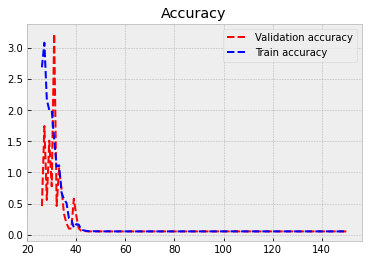

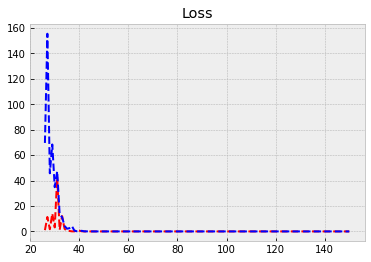

In [23]:
plt.style.use('bmh') # We select as a plot-style 'bmh' that is in my opinion usually the prettiest.
burnout = 25
epochs = range(1, len(history.history['val_mae']) + 1) # Correct x-axis values (epochs)
plt.plot(epochs[burnout:], history.history['val_mae'][burnout:], 'r--',label='Validation accuracy') # Plot epochs vs. accuracy
plt.plot(epochs[burnout:], history.history['mae'][burnout:], 'b--',label='Train accuracy') # Plot epochs vs. accuracy
plt.legend()
plt.title('Accuracy') # Add title
plt.figure() # Show the first figure. Without this command, accuracy and loss would be drawn to the same plot.
plt.plot(epochs[burnout:], history.history['val_loss'][burnout:], 'r--',label='Validation loss') # Plot epochs vs. loss
plt.plot(epochs[burnout:], history.history['loss'][burnout:], 'b--',label='Train loss')
plt.title('Loss') # Add title
plt.show() # Show everyhting

**Evaluate()** can be used to evaluate the model with the test data. Acccuracy with the test data is 0.052.

In [26]:
test_loss,test_acc = model.evaluate(x_test,y_test)

110/110 [==============================] - 0s 248us/step - loss: 0.0066 - mae: 0.0521


In [27]:
test_acc

0.052059270441532135

Let's compare the performance to a linear model.

In [28]:
import sklearn.linear_model as sk_lm

We define our LinearRegression object.

In [29]:
model = sk_lm.LinearRegression()

**fit()** can be used to fit the data.

In [30]:
model.fit(x_train,y_train)

LinearRegression()

**coef_** -attribute has the coefficients of each variable and **intercept_** has the intercept of the linear regression model.

In [31]:
model.coef_

array([ 5.31468126e-08, -1.05923685e-04, -3.53267974e-06, -5.74187084e-07,
        4.89268554e-06,  3.28549174e-08, -1.02011246e-08, -4.32534321e-07,
        3.03267883e-07,  7.33851624e-06,  5.42509020e-07,  5.14662474e-08,
       -1.07960714e-07, -8.41952205e-06, -1.13453398e-06, -1.67169301e-05,
        1.25340601e-05, -1.00876074e-07,  8.42772444e-08,  3.58063483e-07,
        7.40836707e-03,  6.03105032e-04, -4.75728895e-04,  1.11622895e-06,
       -2.38159257e-08,  1.54004100e-02,  9.43484048e-02,  1.94168470e-05,
        2.44164138e-03,  3.21901086e-04, -3.24353490e-02, -1.33602510e-03,
        4.25739547e-01, -3.32303633e-02,  3.77840060e-02, -2.76142065e-03,
       -2.97726456e-04,  2.84737219e-03])

In [32]:
model.intercept_

5.530386213093688

**score()** can be used to measure the coefficient of determination of the trained model. How much our variables are explaining of the variation of the predicted variable.*

In [33]:
model.score(x_test,y_test)

0.42032935471032107

Mean absolute error.

In [34]:
from sklearn.metrics import mean_absolute_error

In [35]:
mean_absolute_error(y_test,model.predict(x_test))

0.03547756137451534

As expected, the linear model performs better for this data.